# Degrees of Influence: Parental Education's Impact on University Dropout Rates
### STAT 201 Project

## Introduction

Higher education institutions are constantly striving to improve student retention and academic success. For this purpose, a comprehensive dataset has been collected from various students in Portugese universities, in an effort to decrease the failure and dropout rate of students (M.V.Martins). The data includes a large number of students with numerous variables that describe each student's unique personal background and their success or failure at the institution. Our project seeks to investigate a specific aspect of this challenge, namely whether the dropout rate among students whose parents **have not** received higher-level education exceeds that of students whose parents **have** attained such educational qualifications. 

#### Background:
A main motivation for this investigation is from a paper by Muthami that examines the relationship between parents’ socio-economic status and students’ dropout rates in secondary schools in Kenya. It finds that parents’ education level, occupation, income, and assets have a significant effect on students’ dropout rates. It also reveals that students with parents who have higher education levels are more likely to drop out than those with parents who have lower education levels.

#### Significance:

The significance of this project lies in its potential to shed light on student dropout rates within the context of parental education. If the data uncovers a statistically significant difference between the two groups, it could inform policies and interventions to better support students. A deeper understanding of this relationship can help institutions tailor their support systems and interventions more effectively, potentially levelling the playing field for all students, regardless of their parental educational backgrounds (Sabates).

#### Research Question

**Is the dropout rate of students with parents that received higher level education greater than those whose parents have not received higher level education?**

- higher level education refers to any education beyond the highschool level
- parents are considered to receive higher level education if **both** parents have received higher level education

$H_0: p_1 = p_2$  
$H_a: p_1 > p_2$  
$p_1$: proportion of student dropout with parents that received higher level education  
$p_2$: proportion of student dropout with parents that have **not** received higher level education

Hypothesis testing will be conducted with $\alpha = 0.05$.

#### Variables of Interest:

Mother's and Father's qualifications, Admission grade. We will also filter students based on variables such as `Educational special needs`, `Tuition fees up to date`, `Daytime/evening attendance` and `Marital Status`.


## Preliminary Analysis

This section will include:
- Retrieving  data from UCI database and importing it into R
- Wrangling and cleaning the data to get a tidy dataset
- Computing the point estimates of the parameter of interest and putting in table for observation
- Plotting relevant data
    - Classifying parents' education levels
    - Calculating relative dropout rates

In [12]:
DATASET_URL <- "https://raw.githubusercontent.com/MehrshadEsm/stat-201-project/main/data.csv"
DATA_FIELDS <- c("Mother's qualification", "Father's qualification", "Educational special needs", "Daytime/evening attendance\t", "Tuition fees up to date", "Marital status", "Admission grade") 
ALPHA <- 0.05
set.seed(1234)

In [13]:
# Load libraries and set seed
library(tidyverse)
library(broom)
library(repr)
library(digest)
library(dplyr)
library(infer)
library(ggplot2)
library(gridExtra)

## Reading and Cleaning Data

The `Target` variable describes 3 possible outcomes for students - "Graduate," "Dropout," or staying "Enrolled." This analysis will specifically focus on the proportion of students who have dropped out.

Moreover, the variables `Mother's qualification` and `Father's qualification` describe the parents' education level, where each number corresponds to the specific education experience (details [here](#Wrangling-and-Visualizing-Data)). Note: the order of these values is arbitrary, and it does not indicate the education level!

In addition to the parental education level, it is equally important to consider other variables that might influence the student dropout rates. Variables such as `Educational special needs`, `Tuition fees up to date`, `Daytime/evening attendance` and `Marital Status` are critical factors that can directly influence the student dropout rates. To elaborate further on this topic, these variables can affect the data in different ways:

- Educational special needs: Students that require special care can cause outliers in the dataset.
- Tuition fees up to date: Reflect the financial status of the students.
- Daytime/evening attendance: Indicates the quality of education students ge; keeping it constant for fair comparison.
- Marital Status: Can cause significant variability in students' lives - single students being the majority and the other students statuses being the outliers.

To minimize the bias cause by other factors, we will filter our population based on a specific character of a subset of students. Moreover, the admission grade of the student is also the significant variable that can provide further insights into our investigation.

In [14]:
# load data from url
student_data_raw <- read_delim(DATASET_URL, delim = ";")

# select target columns
student_data <- 
    student_data_raw |>
    select(Target, all_of(DATA_FIELDS))

head(student_data)
cat("Table 1: Unwrangled Student Data with Relevant Variables")

Rows: 4424 Columns: 37
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr  (1): Target
dbl (36): Marital status, Application mode, Application order, Course, Dayti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Target,Mother's qualification,Father's qualification,Educational special needs,Daytime/evening attendance,Tuition fees up to date,Marital status,Admission grade
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Dropout,19,12,0,1,1,1,127.3
Graduate,1,3,0,1,0,1,142.5
Dropout,37,37,0,1,0,1,124.8
Graduate,38,37,0,1,1,1,119.6
Graduate,37,38,0,0,1,2,141.5
Graduate,37,37,0,0,1,2,114.8


Table 1: Unwrangled Student Data with Relevant Variables

## Wrangling and Visualizing Data 

For the purpose of the analysis, we need to classify parents' education level into two distinct categories - those who have received the higher education, and those who have not received the higher education. In order to be able to classify into these two categories, we will use the UCI dataset definition of the education levels, defined as follows:

- **Received Higher Education:**  
**2** - Bachelor's Degree, 
**3** - Degree, 
**4** - Master's, 
**5** - Doctorate, 
**22** - Technical-professional course, 
**40** - degree (1st cycle), 
**41** - Specialized higher studies course, 
**42** - Professional higher technical course, 
**43** - Master (2nd cycle), 
**44** - Doctorate (3rd cycle),
**39** - Technological specialization course.

- **Have Not Received Higher Education:**  
**1** - Secondary Education, 
**9** - 12th Year of Schooling - Not Completed,
**10** - 11th Year of Schooling - Not Completed, 
**11** - 7th Year, 
**12** - 11th Year of Schooling,
**14** - 10th Year of Schooling 18, 
**19** - Basic Education 3rd Cycle (9th/10th/11th Year), 
**26** - 7th year of schooling, 
**27** - 2nd cycle of the general high school course, 
**29** - 9th Year of Schooling - Not Completed, 
**30** - 8th year of schooling, 
**35** - Can't read or write, 
**36** - Can read without having a 4th year of schooling, 
**37** - Basic education 1st cycle (4th/5th year), 
**38** - Basic Education 2nd Cycle (6th/7th/8th Year). 

- **Outliers (ignored)**:  
**34** - Unknown , 
**6** - Frequency of Higher Education 


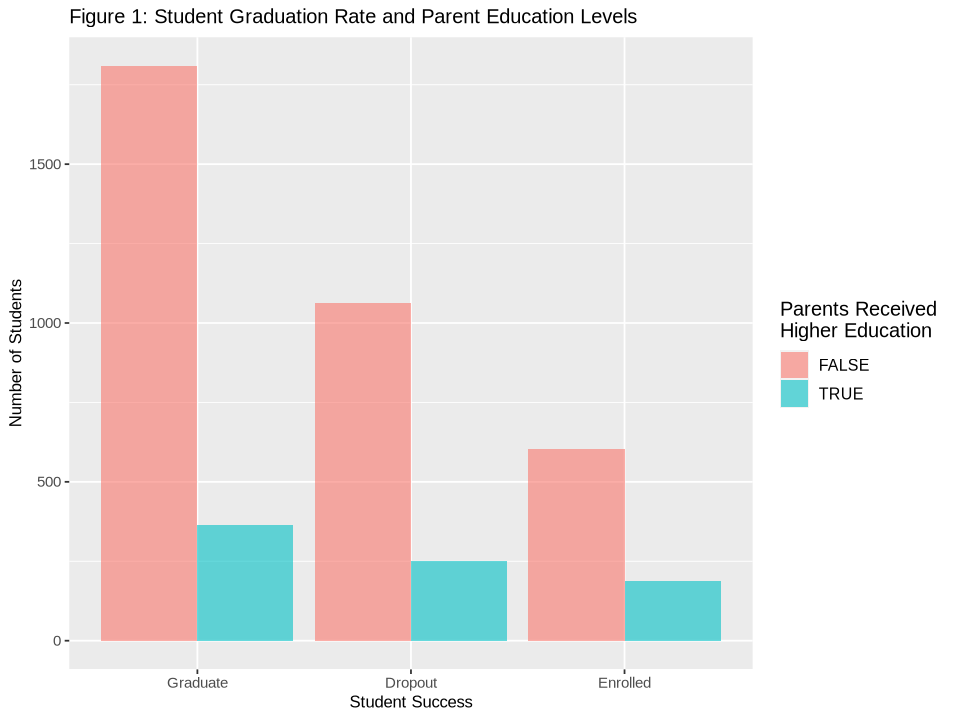

In [12]:
higher_edu = c(2, 3, 4, 5, 22, 40, 41, 42, 43, 44, 39)
not_higher_edu = c(1, 9, 10, 11, 12, 14, 19, 26, 27, 29, 30, 35, 36, 37, 38)
outliers = c(34, 6)

# removing data where parents' education level are outliers / cleaning the data
student_data_edu_unfiltered <- 
    student_data |>
    filter(!(`Mother's qualification` %in%  outliers | `Father's qualification` %in%  outliers)) |>
    mutate(one_higher_edu  = ((`Mother's qualification` %in%  higher_edu) | (`Father's qualification` %in%  higher_edu)),
           both_higher_edu = ((`Mother's qualification` %in%  higher_edu) & (`Father's qualification` %in%  higher_edu)))

# arranging the data according to Target variable (Graduate / Dropout)
arranged_data <-
    student_data_edu_unfiltered %>% 
    group_by(Target) |>
    mutate(n = n())

options(repr.plot.width = 8, repr.plot.height = 6)

# stacked bar chart of categorized data
education_summary_plot <- 
    arranged_data |>
    ggplot(aes(x = reorder(Target, -n), fill = one_higher_edu)) +
      geom_bar(position = "dodge", alpha = .6) +
      xlab("Student Success") +
      ylab("Number of Students") +
      labs(fill = "Parents Received\nHigher Education") +
      theme(text = element_text(size = 12)) + 
      ggtitle("Figure 1: Student Graduation Rate and Parent Education Levels") +
      theme(axis.title = element_text(size = 10), axis.text = element_text(size = 9), plot.title = element_text(size = 12))

education_summary_plot

From the bar above, we can observe that the majority of the students at university, regardless of whether they are dropout, enrolled or graduates, do not have parents where both of parents received higher education. Majority of students in this dataset are either graduates or dropout students. Consequently, for our analysis, we will focus specifically on the "Dropout" students, and "Graduate" and "Enrolled" students will be considered as one group.  We will also calculate the specific proportions to better understand the educational disparity.

## Filtering Data

To minimize the bias caused by other factors, we will filter the data even further - we will consider only students that don't require special education assistance, have paid off all of their tuition fees, have attended day school, and whose marital status is 'single'. These categorical values are represented numerically within the dataset as follows:

- Educational special needs: 1 – yes, **0 – no**
- Tuition fees up to date: **1 – yes**, 0 – no
- Daytime/evening attendance: **1 – Daytime**, 0 – Evening
- Marital Status: **1 – single**, 2 – married, 3 – widower, 4 – divorced, 5 – facto union, 6 – legally separated

In [16]:
# filtering the data considering students that satisfy previously described criteria
student_data_edu <-
    student_data_edu_unfiltered |>
    filter(`Educational special needs` == 0 &
           `Tuition fees up to date` == 1 &
           `Daytime/evening attendance\t` == 1 &
           `Marital status` == 1) |>
    select(-`Educational special needs`, -`Daytime/evening attendance\t`, -`Marital status`, -`Tuition fees up to date`)

head(student_data_edu)
cat("Table 2: Summary of Student Dropout/Graduate Rates with Classification")

Target,Mother's qualification,Father's qualification,Admission grade,one_higher_edu,both_higher_edu
<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
Dropout,19,12,127.3,FALSE,FALSE
Graduate,38,37,119.6,FALSE,FALSE
Graduate,19,38,128.4,FALSE,FALSE
Graduate,1,1,129.3,FALSE,FALSE
Graduate,38,19,130.6,FALSE,FALSE
Graduate,19,38,119.3,FALSE,FALSE


Table 2: Summary of Student Dropout/Graduate Rates with Classification

## Summary of Data

Moreover, we calculate point estimates of the dropout rates using the Central Limit Theorem for both populations, considering the education level is classified as a random binomial value with sample sizes greater than 10 in each category. We will derive estimates for the standard deviation in both populations as follows:

$$\hat{p}\sim N\left(p, \sqrt{\frac{p(1-p)}{n}}\right).$$

Using this, we will calculate the 95% confidence interval for our sample.

In [17]:
# creating the proportion table with the standard deviation
n <- nrow(student_data_edu)

# calculating point estimates for each category: 
# proportions of dropout, sizes, standard deviations, and mean admission grades for students within that category

student_dropout_props_one <-
    student_data_edu |>
    group_by(one_higher_edu) |>
    summarize(`Proportion of Dropout` = sum(Target == "Dropout") / n(),
              Size = n(), 
              `Standard Deviation` = sqrt(`Proportion of Dropout` * (1 - `Proportion of Dropout`) / n),
              lower_ci = `Proportion of Dropout` + qnorm(0.025) * `Standard Deviation`,
              upper_ci = `Proportion of Dropout` + qnorm(0.975) * `Standard Deviation`,
              `Mean Admission Grade` = mean(`Admission grade`))

student_dropout_props_both <-
    student_data_edu |>
    group_by(both_higher_edu) |>
    summarize(`Proportion of Dropout` = sum(Target == "Dropout") / n(),
              Size = n(), 
              `Standard Deviation` = sqrt(`Proportion of Dropout` * (1 - `Proportion of Dropout`) / n),
              lower_ci = `Proportion of Dropout` + qnorm(0.025) * `Standard Deviation`,
              upper_ci = `Proportion of Dropout` + qnorm(0.975) * `Standard Deviation`,
              `Mean Admission Grade` = mean(`Admission grade`))

student_dropout_props_one
cat("Table 3: Summary Table of Dropout Proportions for Students with One Higher-Educated Parent \n\n\n\n")


student_dropout_props_both
cat("Table 4: Summary Table of Dropout Proportions for Students with Both Higher-Educated Parents \n\n\n\n")

one_higher_edu,Proportion of Dropout,Size,Standard Deviation,lower_ci,upper_ci,Mean Admission Grade
<lgl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,0.2102748,2511,0.007261817,0.1960419,0.2245077,126.8448
TRUE,0.2351097,638,0.007556985,0.2202983,0.2499211,129.7033


Table 3: Summary Table of Dropout Proportions for Students with One Higher-Educated Parent 





both_higher_edu,Proportion of Dropout,Size,Standard Deviation,lower_ci,upper_ci,Mean Admission Grade
<lgl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,0.2115123,2936,0.007277445,0.1972487,0.2257758,127.0028
TRUE,0.2676056,213,0.007889215,0.2521431,0.2830682,133.2291


Table 4: Summary Table of Dropout Proportions for Students with Both Higher-Educated Parents 





Although we have generated two tables, we will primarily focus on the case with **both higher-educated parents**. The second table is kept only for the comparison and future analysis purposes. 

The summarized data shows promising initial results. At first glance, our summarized point estimates indicate that the students with parents who have received higher education are more likely to drop out. In addition, the mean admission grade is higher in the group with higher groupout rates. Furthermore, this may imply that academic performance is not the sole factor contributing to the student dropout. Several potential contributing factors include:
- These students may experience more pressure from their parents to excel academically and pursue prestigious careers, which can lead to increased levels of stress, anxiety, and burnout. (Archambault, 2022)
- These students may have more opportunities and resources to explore alternative paths of education or employment, such as online courses, entrepreneurship, or travel.
- These students may both have higher expectations from themselves and from their schools, and this might lead to feelings of dissatisfaction or boredom with the quality or relevance of their education.

## Visualize Data

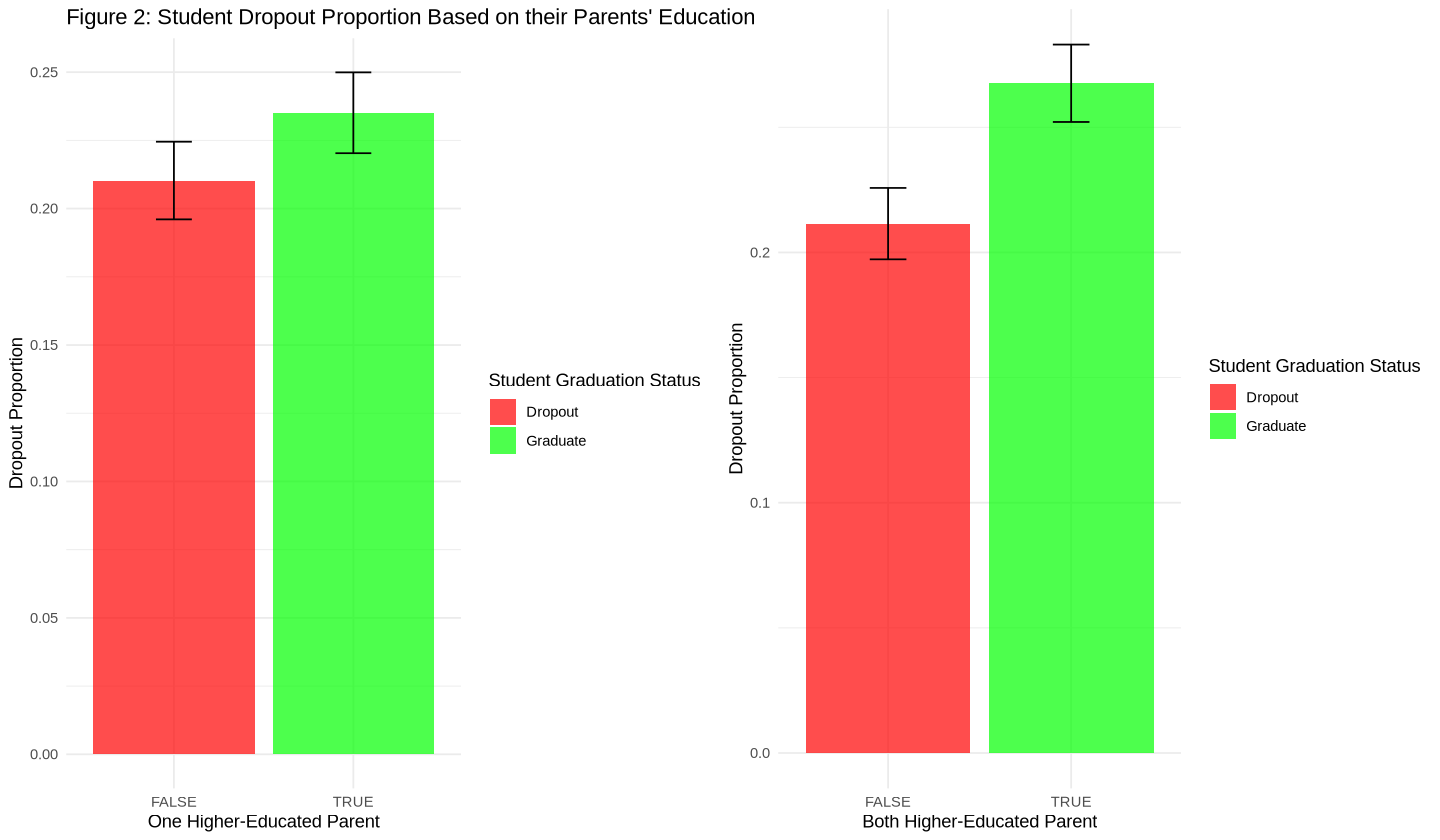

In [13]:
options(repr.plot.width = 12, repr.plot.height = 7)

plot_one_higher_ed_parent <- ggplot(data = student_dropout_props_one, aes(x = factor(one_higher_edu), y = `Proportion of Dropout`, fill = factor(one_higher_edu))) +
  geom_bar(stat = "identity", alpha = .7) +
  geom_errorbar(aes(ymin = lower_ci, ymax = upper_ci),
                    linewidth = 0.5, color = "black", width=.2) +
  labs(title = "Figure 2: Student Dropout Proportion Based on their Parents' Education",
       x = "One Higher-Educated Parent",
       y = "Dropout Proportion") +
  scale_fill_manual(values = c("TRUE" = "green", "FALSE" = "red"), name = "Student Graduation Status", labels = c("Dropout", "Graduate")) +
  theme_minimal()

# plot_one_higher_ed_parent 
plot_both_higher_ed_parent <- ggplot(data = student_dropout_props_both, aes(x = factor(both_higher_edu), y = `Proportion of Dropout`, fill = factor(both_higher_edu))) +
  geom_bar(stat = "identity", alpha = .7) +
    geom_errorbar(aes(ymin = lower_ci, ymax = upper_ci),
                    linewidth = 0.5, color = "black", width=.2) +
  labs(x = "Both Higher-Educated Parent",
       y = "Dropout Proportion") +
  scale_fill_manual(values = c("TRUE" = "green", "FALSE" = "red"), name = "Student Graduation Status", labels = c("Dropout", "Graduate")) +
  theme_minimal()

# plot_both_higher_ed_parent
arranged_plots <- grid.arrange(plot_one_higher_ed_parent, plot_both_higher_ed_parent, ncol = 2)

## Methods and Results

From our preliminary analysis, we have discovered that the students with both higher educated parents have a higher dropout rate. However, the plots and estimates that we produced are not sufficient to provide a conclusive answer, as they do not account for the uncertainty and variability inherent in the data. To address this gap, we propose the following steps in our methods:

1. [Perform hypothesis test using a bootstrap-based approach](#Bootstrap-Based-Hypothesis-Test)
2. [Perform hypothesis test using an asymptotic theory-based approach](#Asymptotic-Theory-Based-Hypothesis-Test)
3. [Compare the two methods](#Results---Comparison-Between-Bootstrapping-and-Theory-Based-Hypothesis-Testing)
4. [Calculate Confidence Intervals and Analyze Errors](#Confidence-Intervals-and-Errors)

### Hypothesis Test
As stated in the [introduction](#Introduction), the hypothesis test will be performed as follows:

$H_0: p_1 = p_2$  
$H_a: p_1 > p_2$  

$p_1$: proportion of student dropouts with parents that received higher level education  
$p_2$: proportion of student dropouts with parents that have **not** received higher level education  

Hypothesis testing will be conducted with $\alpha = 0.05$.

We will perform hypothesis tests with two different approaches: boostrap-based and asymptotic theory-based approach. By verifying the hypothesis test through two different approaches, we can ensure the robustness and reliability of our statistical model.

### Bootstrap-Based Hypothesis Test
The assumptions for conducting a bootstrap-based hypothesis test are as follows:

- The sample(s) are representative of the population(s).
- The sample(s) are large enough to generate a reliable bootstrap distribution.
- The sample(s) are independently and randomly sampled.

Here is the hypothesis test conducted using a bootstrap-based approach:

Observed statistic:  0.0560933722224354 
P-value for bootstrap-based hypothesis test:  0.034 
P-value less than α:  TRUE

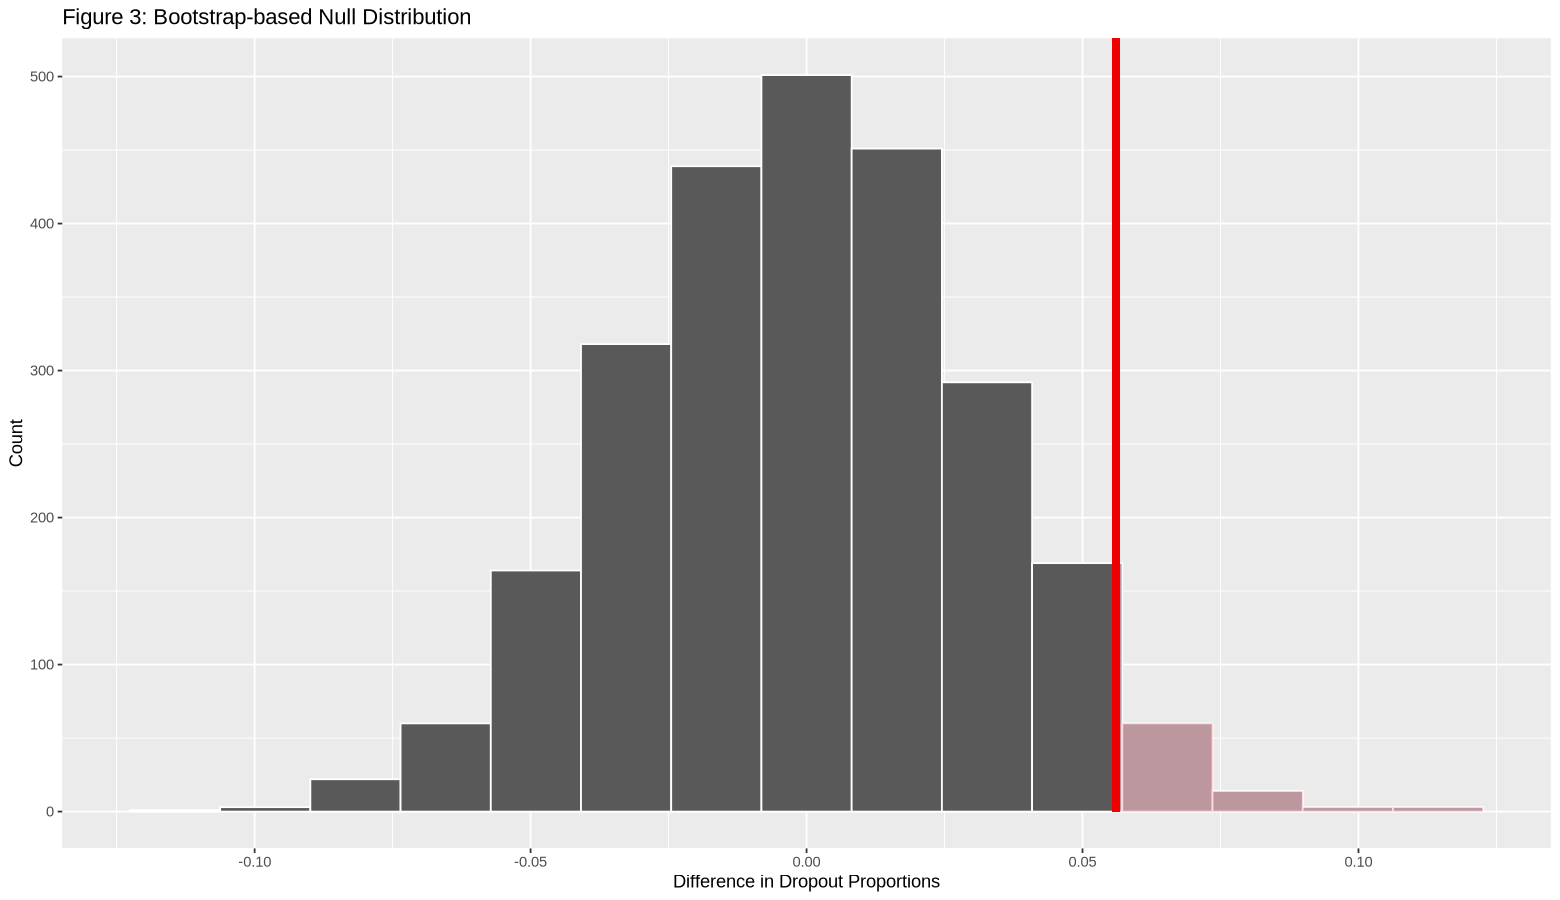

In [19]:
set.seed(222)

options(repr.plot.width = 13, repr.plot.height = 7.5, scipen = 2)

# selects relevant columns and created new one where other than "Dropout" are replaced with "Not-Dropout"
student_data_final <- student_data_edu |>
    select(Target, both_higher_edu) |>
    mutate(Target = ifelse(Target == "Dropout", "Dropout", "Not-Dropout"))

# observed test statistic calculation
obs_stat <- student_data_final |>
    specify(Target ~ both_higher_edu, success = "Dropout") |>
    calculate(stat = "diff in props", order = c(TRUE, FALSE)) |>
    pull()

# bootstrap distribution generating
bootstrap_dist <- student_data_final |>
    specify(formula = Target ~ both_higher_edu, success = "Dropout") |>
    hypothesize(null = "independence") |>
    generate(type = "bootstrap", reps = 2500) |>
    calculate(stat = "diff in props", order = c(TRUE, FALSE))

# create null distribution by shifting bootstrap distribution
null_dist <- bootstrap_dist %>%
    mutate(stat = stat - obs_stat)

# get p-value from null distribution
p_value_bootstrap <- null_dist |>
    get_p_value(obs_stat, direction = "greater")

null_dist |> visualize() + 
    shade_p_value(obs_stat, direction = "greater", size = 1) +
    ggtitle("Figure 3: Bootstrap-based Null Distribution") +
    xlab("Difference in Dropout Proportions") +
    ylab("Count")

cat(paste("Observed statistic: ", obs_stat, "\n"))
cat(paste("P-value for bootstrap-based hypothesis test: ", p_value_bootstrap, "\n"))
cat(paste("P-value less than α: ", p_value_bootstrap < ALPHA))

Because our $p$-value (0.034) is **less** than the significance level of 0.05 , there is sufficient evidence to **reject** the null hypothesis. As such, this indicates there is a statistically significant **difference** that supports the claim students with higher-educated parents have a **larger dropout rate** compared students with less-educated parents.

### Asymptotic Theory-Based Hypothesis Test

To conduct the hypothesis test via asymptotic theory, the following assumptions are made on the basis of the Central Limit Theorem:
- The sample(s) are randomly obtained.
- The sample size(s) are independent (less than of the population size(s))
- The population distribution is normal or the sample size is large enough for each group respectively.

Since we are comparing the population population, we assume normality population distribution which allows us to use the normal approximation with a $z$-distribution. Below is the hypothesis test conducted with a asymptotic approach.


Confidence Interval (asymptotic method): [ -0.005167894 ,  0.1173546 ]
Observed statistic:  0.05609337 
P-value for the asymptotic hypothesis test:  0.02723024 
P-value less than α:  TRUE 


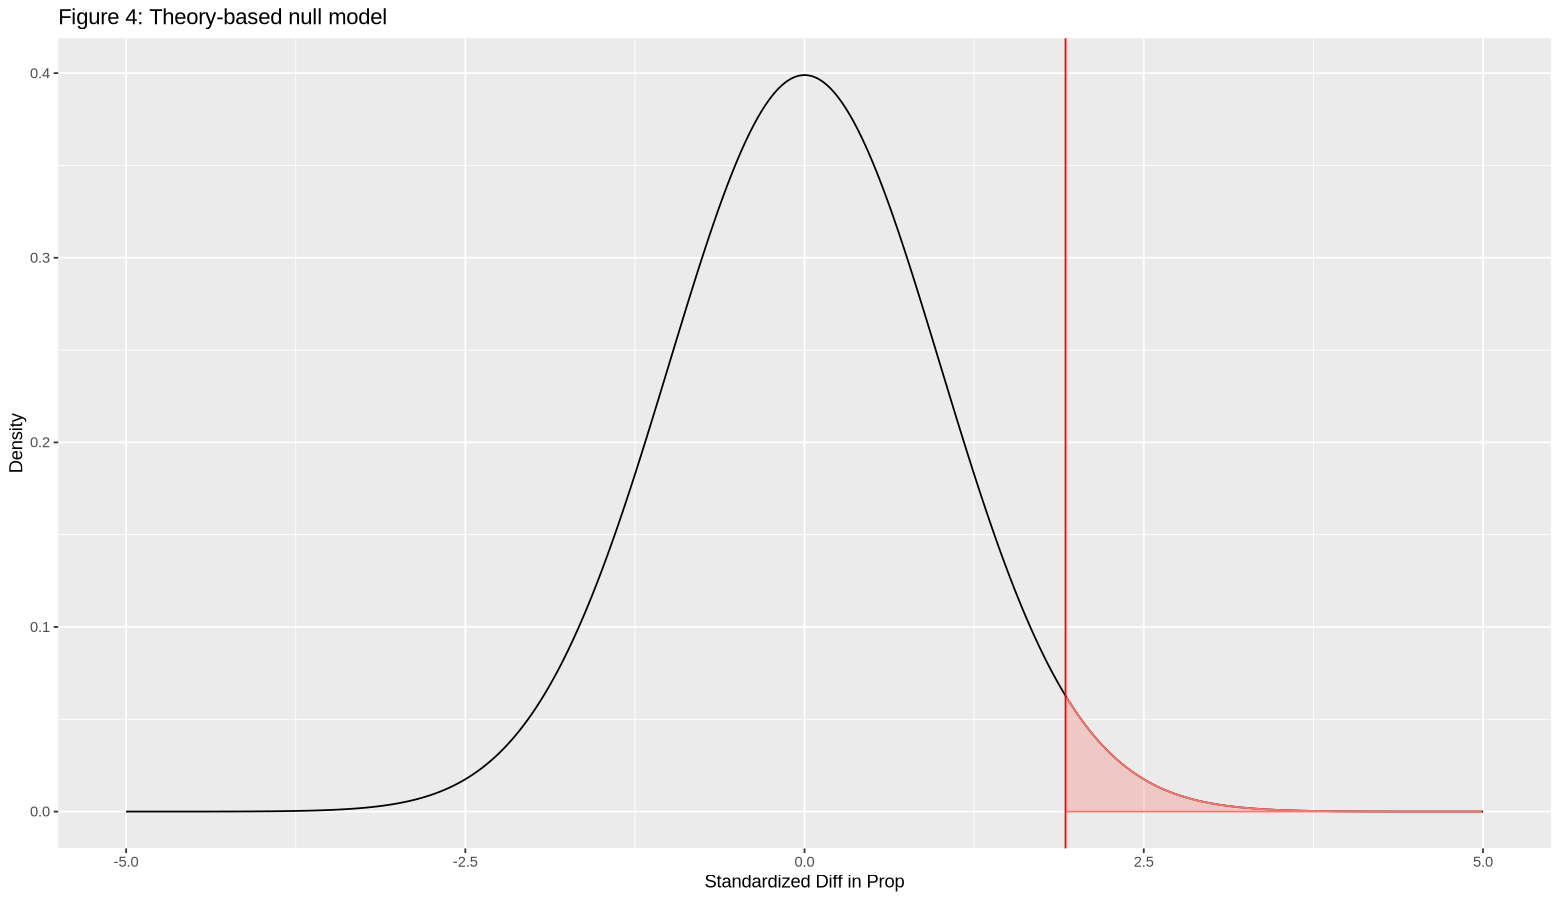

In [28]:
# To remain cohesion, the seeds are being set to the same value as Bootstrap hypothesis test
set.seed(222)

# Calculate the dropout rate on the group of students with both parents receiving high-level education
both_edu_dropout_data <- student_data_final %>% 
    group_by(both_higher_edu) %>%
    summarize(n = n(),
              prop = sum(Target == "Dropout") / n, 
              se = sqrt(prop * (1 - prop) / n()), 
              lower_ci = prop - qnorm(1 - ALPHA / 2) * se, 
              upper_ci = prop + qnorm(1 - ALPHA / 2) * se)

# Calculate p hat (pooled proportion) and test statistic (Z)
p_both <- both_edu_dropout_data$prop[2]
p_no <- both_edu_dropout_data$prop[1]
n_both <- both_edu_dropout_data$n[2]
n_no <- both_edu_dropout_data$n[1]

p_pooled <- (p_both * n_both + p_no * n_no) / (n_both + n_no)
z <- qnorm(1 - ALPHA / 2)
p_obs_standardized <- (p_both - p_no) / (sqrt(p_pooled*(1-p_pooled)*(1/n_both + 1/n_no)))

# Calculate the confidence interval
lower_ci_asym <- (p_both - p_no) - z * sqrt((p_both * (1 - p_both) / n_both) + (p_no * (1 - p_no) / n_no))
upper_ci_asym <- (p_both - p_no) + z * sqrt((p_both * (1 - p_both) / n_both) + (p_no * (1 - p_no) / n_no))

# Display the confidence interval
cat("Confidence Interval (asymptotic method): [", lower_ci_asym, ", ", upper_ci_asym, "]\n")

# Calculate the observed statistic for the asymptotic hypothesis test
cat("Observed statistic: ", (p_both - p_no), "\n")

# Display p-value for the asymptotic hypothesis test
summary_table <- tidy(prop.test(x = c(p_both * n_both, p_no * n_no), 
                                n = c(n_both, n_no), 
                                correct = FALSE, 
                                alternative = "greater", 
                                conf.level = 1 - ALPHA))

cat("P-value for the asymptotic hypothesis test: ", summary_table$p.value, "\n")

cat("P-value less than α: ", summary_table$p.value < ALPHA, "\n")


# Create null model for the theory-based null model plot
plot_range <- tibble(lower = -5, upper = 5)
null_model_theory <- tibble(t = seq(from = plot_range$lower, to = plot_range$upper, by = 0.01), density = dnorm(t))

# Plot null model
ggplot(null_model_theory) + 
    geom_line(aes(x = t, y = density)) + 
    geom_ribbon(data = subset(null_model_theory, t > p_obs_standardized & t < plot_range$upper), 
                mapping = aes(x = t, ymax = density, fill = "red", color = "red"), ymin = 0, alpha = 0.3) +
    geom_vline(aes(xintercept = p_obs_standardized), color = 'red') +
    theme(legend.position = "none") +
    ggtitle("Figure 4: Theory-based null model") +
    xlab("Standardized Diff in Prop") +
    ylab("Density")

From the asymptotic test, we obtain a $p$-value of 0.0272, which is **below** the significance level value of 0.05. Consequently, we can make a conclusion there is also sufficient evidence to **reject** the null hypothesis, which also indicated that our results are statistically significant. 

Under the same significance level and dataset, the results from both asymptotic theory-based and bootstrap-based approach are consistent with each other. Therefore, it is justified to conclude that the dropout proportion among students with both higher-educated parents is **higher** compared to those with one higher-educated parent. 

### Results - Comparison Between Bootstrapping and Theory-Based Hypothesis Testing


The two approaches, bootstrapping and theory-based, can yield different $p$-values due to the variability of the sampling randomness and the assumptions made. Bootstrapping involves random samples and thus variation in the mean differences, whereas asymptotic theory provides an estimation of the sampling distribution with uncertainty in the truth of the assumptions made (Central Limit Theorem). This variation in $p$-value is **non-trivial** in comparison to our chosen significance level of 0.05, and consequently, it brings focus to the reliability of the approaches used.

#### Agreement in Results:

Both bootstrapping and asymptotic theory yielded $p$-values below the significance level (0.05). The asymptotic method gave a lower $p$-value in comparison and rejected the null hypothesis with greater certainty. The consistent rejection of the null hypothesis across both methods strengthens the evidence for a significant difference in dropout proportions based on parental education. This supports the robustness of the utilized statistical model.

#### Addressing Variability:

Bootstrapping's consideration of random samples introduces variability in mean differences, reflecting real-world uncertainties and does not rely on any assumptions.
Asymptotic theory assumes normality, and its variation in $p$-value acknowledges uncertainties related to these assumptions. Bootstrapping might be preferable when assumptions about data distribution are unclear or violated.

Example: "This variation in $p$-value is considered non-trivial as it surpasses the commonly chosen significance level of 0.05, indicating a substantial difference that merits attention in evaluating the reliability of the statistical approaches."

#### Further Insights:

While both methods arrived at the same conclusion, each approach offers unique insights into the data and underlying assumptions.
The convergence of results from distinct methodologies enhances the overall validity of the statistical inferences.
Combining multiple methods can provide a more nuanced understanding and strengthen the overall statistical analysis.
In summary, the variation in $p$-values between bootstrapping and asymptotic theory underscores the importance of understanding the methodologies' intricacies. The consistent results affirm the reliability of the statistical model, and the strengths and limitations associated with each approach should be evaluated in the context of specific analyses. 

Bootstrapping here proves to be quite a versatile tool since we don't know much about our population of interest and want to gain a better understanding of our proposed statistical hypothesis. This allows a computationally easy method, without the requirement of any assumptions about our data to provide insight on our statistical problem.

### Confidence Intervals and Errors
It is important to consider the confidence intervals and errors in a statistical test because they provide information about the uncertainty and accuracy of the estimate, the effect size, and the generalizability of the results. As such, we calculate the confidence interval and the errors associated to the **difference** in dropout proportions ($p_1 - p_2$).

In [29]:
set.seed(222)

# bootstrap-based approach confidence intervals
bootstrap_ci <-
    get_confidence_interval(x = bootstrap_dist, level = 1 - ALPHA, type = "percentile", point_estimate = obs_stat)

# asymptotic-based approach confidence intervals
asymptotic_ci <- tibble( lower_ci = lower_ci_asym, upper_ci = upper_ci_asym)


cat("Bootstrap-based Approach Confidence Interval: [", bootstrap_ci$lower_ci, ", ", bootstrap_ci$upper_ci, "]\n")
cat("Asymptotic Theory-based Approach Confidence Interval: [", asymptotic_ci$lower_ci, ", ", asymptotic_ci$upper_ci, "]\n")

pwr_analysis <- power.prop.test(n = c(n_both, n_no),
                                p1 = p_both, p2 = p_no,
                                sig.level = ALPHA, alternative = "one.sided")

cat("Probability of a Type I error: ", ALPHA, "\n")
cat("Probability of a Type II error: ", pwr_analysis$power[1], "\n")
cat("Power: ", 1 - pwr_analysis$power[1])

Bootstrap-based Approach Confidence Interval: [ -0.005660928 ,  0.1162186 ]
Asymptotic Theory-based Approach Confidence Interval: [ -0.005167894 ,  0.1173546 ]
Probability of a Type I error:  0.05 
Probability of a Type II error:  0.3862123 
Power:  0.6137877

Comparing the bootstrap-based and asymptotic-based confidence intervals for the difference in dropout proportions provides valuable insights. The bootstrap interval spans from -0.00566 to 0.1162. This result is consistent with the aysmptotic-based interval of -0.00517 to 0.1174. As such, this reinforces the results that there is a 95% chance of the interval [-0.00566, 0.1162] capturing the true difference in proportions.

Since both intervals have a slight negative component, it indicates uncertainty regarding which group—students with more or less-educated parents—exhibits a higher dropout rate. Ideally, we would want the 95% confidence interval to fall outside of the null value, since that is the expected result if we reject the null hypothesis. This reflects a limitation of our statistical model, and this discrepancy could be a result of the assumptions used in the analysis being incorrect. Hence, it is important to re-evaluate this problem with a set of more robust statistical tools in the future.

A critical aspect of the analysis is the evaluation of error probabilities. Due to their complexity, the errors are only calculated relative to the asymptotic method. The probability of a Type II error is 0.386. This indicates there is a 38% chance of failing to reject a wrong null hypothesis. In conjunction with this value, the power of the test is 0.613, which represents there is 61% we correctly rejected the null hypothesis correctly. The power of our statistical test can be improved further, since there still remains a significant chance that a change is not detected properly. Therefore, further investigations with other data sets and other methods should be conducted in the future to consolidate our results.

### Visualize Confidence Intervals and Errors

Asymptotic Theory-based Approach Confidence Interval: [ -0.005167894 ,  0.1173546 ]


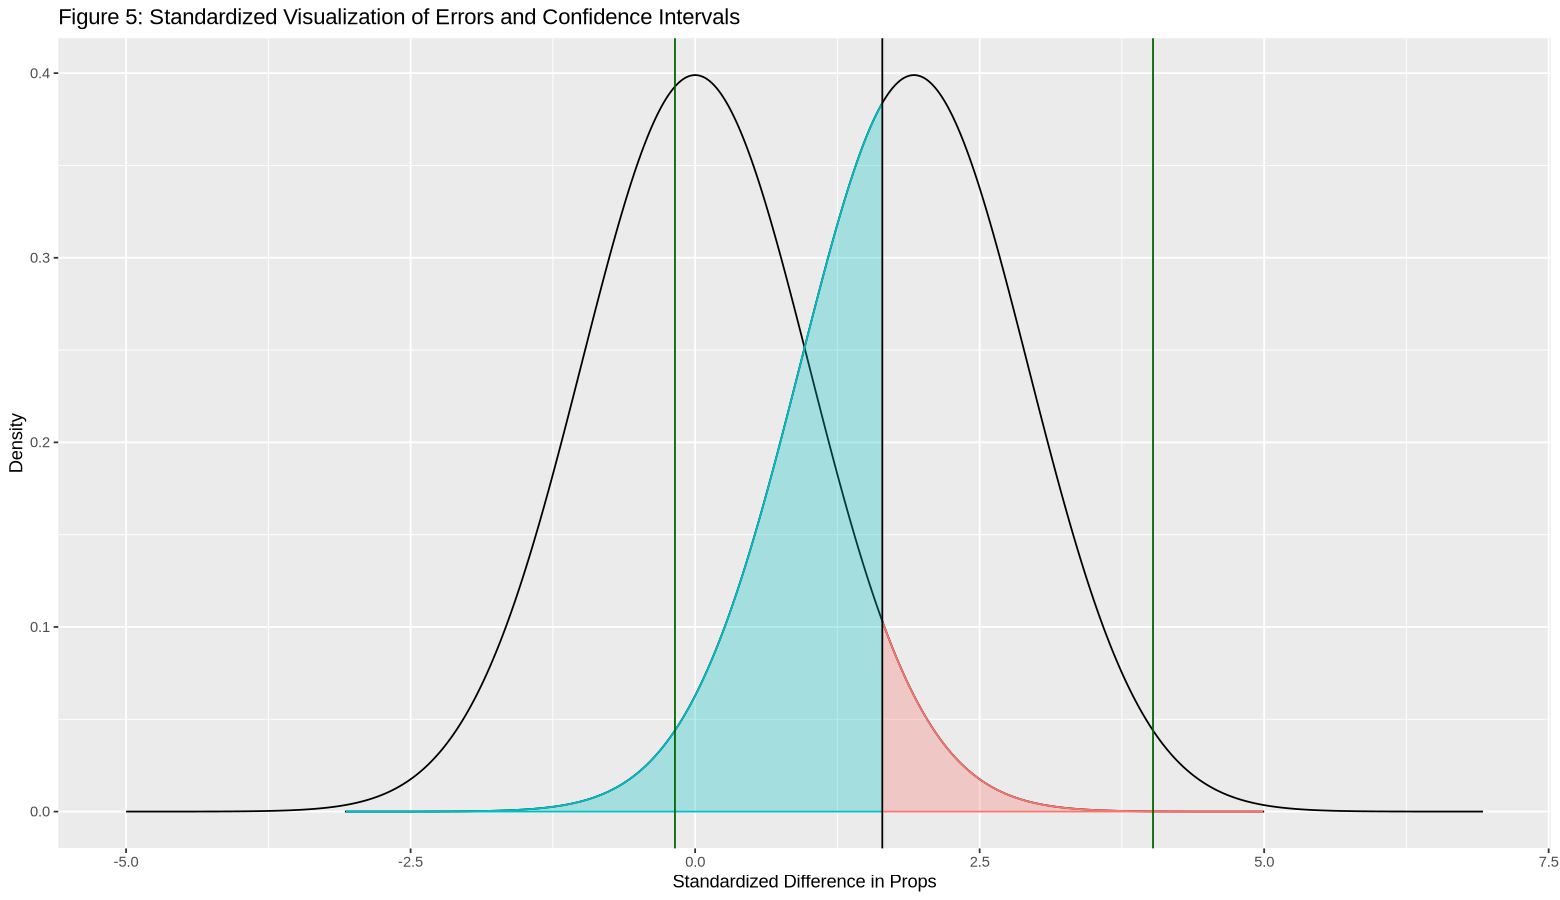

In [30]:
# Visualize Confidence Intervals
alternative_model <- null_model_theory |> mutate(t = t + p_obs_standardized)
critical_value = qnorm(0.95)

error_plot <- ggplot(null_model_theory) + 
    geom_line(aes(x = t, y = density)) + 
    geom_line(data = alternative_model, aes(x = t, y = density)) + 
    geom_ribbon(data = subset(null_model_theory, t > critical_value & t < plot_range$upper), 
                mapping = aes(x = t, ymax = density, fill = "blue", color = "blue"), ymin = 0, alpha = 0.3) +
    geom_ribbon(data = subset(alternative_model, t > plot_range$lower + p_obs_standardized & t < critical_value), 
                mapping = aes(x = t, ymax = density, fill = "red", color = "red"), ymin = 0, alpha = 0.3) +
    geom_vline(aes(xintercept = critical_value), color = 'black') + 
    geom_vline(aes(xintercept = asymptotic_ci$lower_ci / (sqrt(p_pooled*(1-p_pooled)*(1/n_both + 1/n_no)))), color = 'darkgreen') + 
    geom_vline(aes(xintercept = asymptotic_ci$upper_ci / (sqrt(p_pooled*(1-p_pooled)*(1/n_both + 1/n_no)))), color = 'darkgreen') +
    theme(legend.position = "none") +
    ggtitle("Figure 5: Standardized Visualization of Errors and Confidence Intervals") +
    xlab("Standardized Difference in Props") +
    ylab("Density") +
    labs(fill = "Errors", colour = "Confidence Inerval")

error_plot
cat("Asymptotic Theory-based Approach Confidence Interval: [", asymptotic_ci$lower_ci, ", ", asymptotic_ci$upper_ci, "]\n")


In the plot above, the **confidence interval** is denoted by the **green** bars. The probability of **type I error** is the **red** area. Similarly, the probability of **type II error** is the **blue** area. Lastly, the critical value is denoted by the vertical **black** bar. This visualization can help us understand our statistical model better, and visually verify the numerical values we calculated earlier.

## Discussion

### Summary
From our background research, there was a general consensus that parent who attained higher educational achievements, resulted in students with higher dropout rates. This unsusal result prompted us to investigate this problem with a dataset of students in a collection of Portugese universities.

Our analysis of the relationship between parental education levels and student dropout rates yielded expected results. We have concluded that **there is sufficient statistical evidence** to suggest that the dropout rate of students whose parents are better educated is **greater** than the academic performance of students whose parents are less educated. Through the analysis of both a bootstrapping and asymptotical-based approaches, we have determined that both approaches yielded sufficient evidence to reject our null hypothesis. 

While our invesitgation solely does focus on the importance of the education level of a parent, it is crucial to note that student dropout rate is not solely influenced by the parent's education attainment, but by a variety of many other factors. Additionally, our power value of 0.61 indicates there is still room for improvement. With the consistent results of our conclusions during our hypothesis testing approaches and given our calculated $p$-values being less than our set significance level, we have plausible evidence to reject our null hypothesis. However, the confidence intervals we have calculated may reveal a flaw in our statstictal methodology, and this investigation should be re-evaluated with more robust statistical methods to ensure the conclusion is valid.

### Possible Improvements

To strengthen the statistical analysis, several key enhancements can be implemented. Firstly, incorporating additional independent variables, such as socio-economic status and prior academic performance, would contribute to a more comprehensive understanding of the factors influencing student dropout rates. Exploring interaction effects between parental education and other relevant variables, can reveal nuanced patterns in the data. Conducting a longitudinal analysis over time would provide insights into trends and potentially uncover causal relationships. Ensuring a representative and independent samples for two-sample tests are essential for drawing meaningful conclusions, while addressing outliers and maintaining clarity in variable definitions is crucial to minimizing bias. Similarly, controlling confounding variables and increasing precision can help improve the power of the statistical test. Lastly, statistical results should be accompanied by qualitative research, such as interviews with students, parents, and educators, can offer a richer context to the statistical findings. 

### Implications and Impact of Our Results

The significance of our findings extends beyond statistical differences, as it prompts reevaluating existing assumptions and beliefs surrounding student success and dropout rates. Our results emphasize that we should also look into the non-academic factors, such as parental expectations, alternative educational opportunities, rather than only academic performance alone, when doing analysis in this area. Therefore, results from our analysis suggest that recognizing these factors is crucial for learning more about the dropout rates and how to reduce it, and tailor effective support educational systems and inclusive environment for students.

### Future Research Questions

1. What other non-researched specific factors contribute to the higher dropout rates among students with both parents having higher education?

2. How can future research offer more tailored results and advice to address challenges faced by students with highly educated parents?

3. How would extension of this study to different educational settings broaden the understanding of the relationship between parental education and student success rates?

### Conclusion:

Our analysis provides valuable insights of the relationship between student dropout rates and their parents educational level. The unexpected findings highlight how important is it to have tailored approach when it comes to understanding the dropout rates. Recognizing the different factors in students lives would help develop educational institutions develop more effective strategies for supporting their students and minimizing the dropout rate. Our research establishes a foundation for future analyses, highlighting the significance of considering both statistical methodologies, as well as the real-world implications in educational research.

## References

Archambault, I., Janosz, M., Olivier, E., &amp; Dup&amp;eacute;r&amp;eacute;, V. (2022). Student engagement and school dropout: Theories, evidence, and future directions. SpringerLink. https://link.springer.com/chapter/10.1007/978-3-031-07853-8_16 

M.V.Martins, D. Tolledo, J. Machado, L. M.T. Baptista, V.Realinho. (2021) "Early prediction of student’s performance in higher education: a case study" Trends and Applications in Information Systems and Technologies, vol.1, in Advances in Intelligent Systems and Computing series. Springer. DOI: 10.1007/978-3-030-72657-7_16

Muthami, S. K., Cheloti, S. K., &amp; Mwania, J. M. (2023). Parents’ socio-economic status as a determinant of students’ dropout ... International Journal of Management Studies and Social Science Research. https://ijmsssr.org/paper/IJMSSSR00996.pdf 

Predicting student dropout and academic success. UC Irvine Machine Learning Repository. (2021). https://mdpi-res.com/d_attachment/data/data-07-00146/article_deploy/data-07-00146.pdf?version=1666954490 

Sabates, R., Hunt, F., Westbrook, J., &amp; Akyeampong, K. (2010). School drop out: patterns, causes, changes and policies. Unesdoc.unesco.org. https://unesdoc.unesco.org/ark:/48223/pf0000190771 